Inspired by : https://www.kaggle.com/code/zakarii/dna-sequence-classification-cnn-gru

# Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
work_folder = "/content/drive/MyDrive/Promoters_classification/"
non_promoters_set = work_folder + "NonPromoterSequence.txt"
promoter_set = work_folder + "PromoterSequence.txt"
models_folder = "/content/drive/MyDrive/Promoters_classification/models/"


# Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import  tensorflow as tf
import keras
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split

## Loading and cleaning non promoters sequences set

In [ ]:
df_non_promoters = pd.read_csv(non_promoters_set, sep = '>', )
df_non_promoters.dropna(subset=['Unnamed: 0'], how='all', inplace=True)
df_non_promoters.reset_index(inplace = True)
df_non_promoters.drop(['EP 1 (+) mt:CoI_1; range -400 to -100.', 'index'], axis = 1, inplace=True) #data cleaning after error found
df_non_promoters.rename(columns={'Unnamed: 0': "sequence"}, inplace = True)
df_non_promoters['label'] = 0
display(df_non_promoters)
display(df_non_promoters.shape)

,sequence,label
0,TAATTACATTATTTTTTTATTTACGAATTTGTTATTCCGCTTTTAT...,0
1,ATTTTTACAAGAACAAGACATTTAACTTTAACTTTATCTTTAGCTT...,0
2,AGAGATAGGTGGGTCTGTAACACTCGAATCAAAAACAATATTAAGA...,0
3,TATGTATATAGAGATAGGCGTTGCCAATAACTTTTGCGTTTTTTGC...,0
4,AGAAATAATAGCTAGAGCAAAAAACAGCTTAGAACGGCTGATGCTC...,0
...,...,...
11295,TGGTAAAAAATTGTACACCTAACTAGTGCCTTCATGTATACCACCA...,0
11296,AGTGCAACTGGAGCCGTGCCGTGACCCACAGAGATCGCCCACTCGA...,0
11297,GCATGGATTTCATATTATCTTAATCGACTTGCTTTTATAAAATAGG...,0
11298,GTGACCAGGTTTTGCTCTAATGCGAAGTACGGATTGGGTAGAGATA...,0


(11300, 2)

## Loading and cleaning  promoters sequences set

In [ ]:
df_promoters = pd.read_csv(promoter_set, sep = '>', )
df_promoters.dropna(subset=['Unnamed: 0'], how='all', inplace=True)
df_promoters.reset_index(inplace = True)
df_promoters.drop(['EP 1 (+) mt:CoI_1; range -100 to 200.', 'index'], axis = 1, inplace=True) #data cleaning after error found
df_promoters.rename(columns={'Unnamed: 0': "sequence"}, inplace = True)
df_promoters['label'] = 1
display(df_promoters)
display(df_promoters.shape)

,sequence,label
0,TTAATTTGTCCTTATTTGATTAAGAAGAATAAATCTTATATATAGA...,1
1,ATAGCTCAAATTGCTTTATTAGTATTAGAATCAGCTGTAGCTATAA...,1
2,AAGCTTCCCTTTAATGTGCTCCTTGTGAATACAGCATTACAATGCC...,1
3,TATGTAGAATCTGTACAAGTATCTGTGTTTGGACAATGGCATGTGT...,1
4,ACATATTACTGCATACAGGTCTCAAATTATAAAATGACACTCGTGG...,1
...,...,...
11295,CGACAAAGTTTGATCCATGTGCATTCTTGGCGCCTTATCGATAGCT...,1
11296,CATATCTACATCTCGCTTGCTCCTTCCCTTTCGCTGCGTGTGTGTG...,1
11297,ATACCGCGGAAGCGCAAAAGTACCAGAATTTCCCTGGTATCGCGCT...,1
11298,ATTATTCCGAATTCTTTTATCAGATTTAAATATGGGAAACACTTTA...,1


(11300, 2)

## Merge non promoters and promoters sequences dataset to perform analyses on

In [ ]:
df = pd.concat([df_non_promoters, df_promoters], axis = 0 )
print(f"Shape of the full dataset: {df.shape}")
# df.head(5)
print(df.head(5))

Shape of the full dataset: (22600, 2)
                                            sequence  label
0  TAATTACATTATTTTTTTATTTACGAATTTGTTATTCCGCTTTTAT...      0
1  ATTTTTACAAGAACAAGACATTTAACTTTAACTTTATCTTTAGCTT...      0
2  AGAGATAGGTGGGTCTGTAACACTCGAATCAAAAACAATATTAAGA...      0
3  TATGTATATAGAGATAGGCGTTGCCAATAACTTTTGCGTTTTTTGC...      0
4  AGAAATAATAGCTAGAGCAAAAAACAGCTTAGAACGGCTGATGCTC...      0


## Drop uninformative sequences (containing 'N' nucleotides)

In [ ]:
nb_sequences_to_drop = 0
rows_indexes_to_drop = list()

for idx, seq in enumerate(df['sequence']):
    if 'N' in seq:
      nb_sequences_to_drop +=1
      # display(df.loc[df['sequence'] == seq])

      rows_indexes_to_drop.append(idx)
      


print(f"Number of sequence to be dropped : {nb_sequences_to_drop}")
print(f"Rows to be dropped : {rows_indexes_to_drop}")

print(f"Shape of the data before dropping sequences containing Ns : {df.shape}")

df.drop(rows_indexes_to_drop, inplace = True)

print(f"Shape of the data after dropping sequences containing Ns : {df.shape}")


Number of sequence to be dropped : 1
Rows to be dropped : [1822]
Shape of the data before dropping sequences containing Ns : (22600, 2)
Shape of the data after dropping sequences containing Ns : (22598, 2)


### Encode sequences with one-hot strategy. 

Each base will be considered as a 4-uplet of binary values (either 0 or 1) to be processed with the CNN.
A -> [1,0,0,0]
T -> [0,1,0,0]
C -> [0,0,1,0]
G -> [0,0,0,1]



In [ ]:
sequence = list(df.loc[:, 'sequence'])
encoded_list = []

def encode_seq(s):
    Encode = {'A':[1,0,0,0],'T':[0,1,0,0],'C':[0,0,1,0],'G':[0,0,0,1]}
    return [Encode[x] for x in s]

for i in sequence:
    x = encode_seq(i)
    encoded_list.append(x)

X = np.array(encoded_list)
print(f" Shape of one-hot encoded sequences: {X.shape}")

 Shape of one-hot encoded sequences: (22598, 301, 4)


In [ ]:
df.get("label").iloc[0]

0

## Visualize an encoded sequence

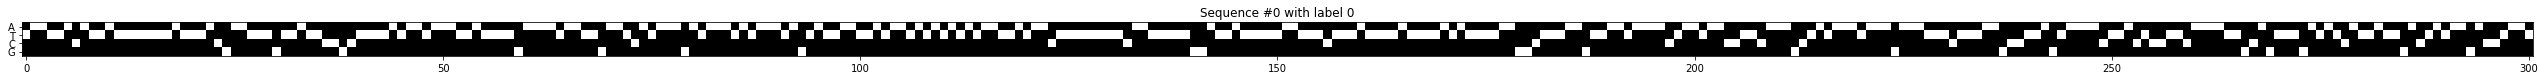

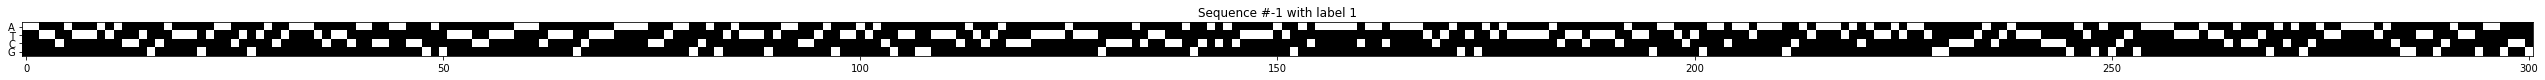

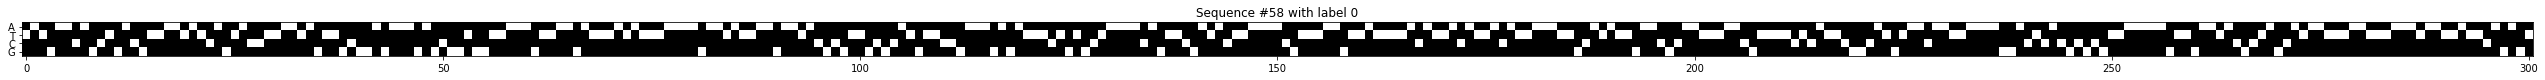

In [ ]:
plt.figure(figsize=(45,45))
plt.title(f"Sequence #0 with label {df.get('label').iloc[0]}")
plt.imshow(X[0].T, cmap = "binary_r")
plt.yticks([0, 1, 2,3], ['A', 'T', 'C', 'G'] , rotation=0)
plt.show()

plt.figure(figsize=(45,45))
plt.title(f"Sequence #-1 with label {df.get('label').iloc[-1]}")
plt.imshow(X[-1].T, cmap = "binary_r")
plt.yticks([0, 1, 2,3], ['A', 'T', 'C', 'G'] , rotation=0)
plt.show()

plt.figure(figsize=(45,45))
plt.title(f"Sequence #58 with label {df.get('label').iloc[58]}")
plt.imshow(X[58].T, cmap = "binary_r")
plt.yticks([0, 1, 2,3], ['A', 'T', 'C', 'G'] , rotation=0)
plt.show()

## Reshape sequences dataset and separate sequences from their labels


In [ ]:
X = X.reshape(X.shape[0],301, 4, 1) # Tensor containing one-hot encoded sequences wich are promotors or not
y = df['label'] # Tensor containing labels for each sequence (0 : sequence is nt a promotor, 1 : sequence is a promotor)
print(y.value_counts())


print(f"Shape of tensor containing sequences one-hot encoded {X.shape}\n")
print(f"Shape of tensor containing labels relatives to the sequences : {y.shape}")

if(X.shape[0] != y.shape[0]):
  raise ValueError('Sequence tensor and lebels tensor need to have corresponding shapes')



0    11299
1    11299
Name: label, dtype: int64
Shape of tensor containing sequences one-hot encoded (22598, 301, 4, 1)

Shape of tensor containing labels relatives to the sequences : (22598,)


## Split data into train, test and validation sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y, shuffle = True, test_size = 0.2) # Split data into train and test
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, random_state = 42, stratify = y_test, shuffle = True, test_size = 0.5) # Split data into test and validation

In [ ]:
print(y_train.value_counts())
print(y_test.value_counts())
print(y_validation.value_counts())

0    9039
1    9039
Name: label, dtype: int64
0    1130
1    1130
Name: label, dtype: int64
1    1130
0    1130
Name: label, dtype: int64


## Base model

In [ ]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv1D(filters = 27, kernel_size = 4, activation = 'relu', padding = "valid", input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(tf.keras.layers.MaxPool1D(pool_size=3, strides=None, padding='valid'))
model.add(tf.keras.layers.Conv1D(filters = 14, kernel_size = 4, activation = 'relu'))
model.add(tf.keras.layers.MaxPool1D(pool_size= 2, strides = None, padding = 'valid'))
model.add(tf.keras.layers.Conv1D(filters = 7, kernel_size = 4, activation = 'relu'))
model.add(tf.keras.layers.MaxPool1D(pool_size= 2, strides = None, padding = 'valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

# Set early stopping to avoid overfitting

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0005, patience=8, 
                                           restore_best_weights=True )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 298, 27)           459       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 99, 27)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 14)            1526      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 48, 14)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 45, 7)             399       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 22, 7)            0

In [ ]:
history = model.fit(X_train, y_train, batch_size = 128, validation_data=(X_test, y_test), 
                        epochs=115)

model.save(models_folder)

Epoch 1/115
142/142 [==============================] - 7s 41ms/step - loss: 0.6914 - accuracy: 0.5257 - val_loss: 0.6841 - val_accuracy: 0.5686
Epoch 2/115
142/142 [==============================] - 6s 40ms/step - loss: 0.6786 - accuracy: 0.5915 - val_loss: 0.6709 - val_accuracy: 0.6243
Epoch 3/115
142/142 [==============================] - 6s 39ms/step - loss: 0.6568 - accuracy: 0.6492 - val_loss: 0.6419 - val_accuracy: 0.6695
Epoch 4/115
142/142 [==============================] - 6s 39ms/step - loss: 0.6148 - accuracy: 0.6968 - val_loss: 0.5944 - val_accuracy: 0.6942
Epoch 5/115
142/142 [==============================] - 6s 39ms/step - loss: 0.5669 - accuracy: 0.7240 - val_loss: 0.5632 - val_accuracy: 0.7053
Epoch 6/115
142/142 [==============================] - 6s 39ms/step - loss: 0.5393 - accuracy: 0.7361 - val_loss: 0.5607 - val_accuracy: 0.7066
Epoch 7/115
142/142 [==============================] - 5s 39ms/step - loss: 0.5261 - accuracy: 0.7433 - val_loss: 0.5447 - val_accuracy:

In [ ]:
# Evaluate the model
loss, acc = model.evaluate(X_validation, y_validation, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

71/71 - 0s - loss: 0.3656 - accuracy: 0.8403 - 286ms/epoch - 4ms/step
Untrained model, accuracy: 84.03%


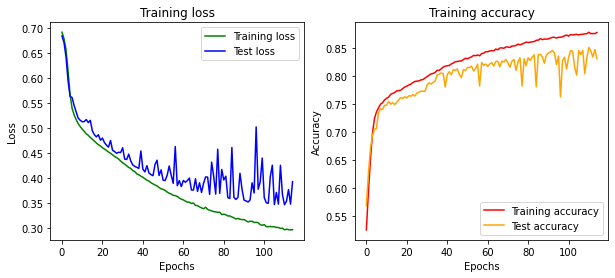

In [ ]:
plt.figure(figsize = (10,4))
plt.subplot(121)
plt.plot(history.epoch, history.history["loss"], 'g', label='Training loss')
plt.plot(history.epoch, history.history["val_loss"], 'b', label='Test loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.epoch, history.history["accuracy"], 'r', label='Training accuracy')
plt.plot(history.epoch, history.history["val_accuracy"], 'orange', label='Test accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(work_folder + "base_model_deep_no_dropout_sgd.png")
plt.show()

# Adam Model

In [ ]:
model_adam = tf.keras.Sequential()

model_adam.add(tf.keras.layers.Conv1D(filters = 27, kernel_size = 4, activation = 'relu', padding = "valid", input_shape = (X_train.shape[1], X_train.shape[2])))
model_adam.add(tf.keras.layers.MaxPool1D(pool_size=3, strides=None, padding='valid'))
model_adam.add(tf.keras.layers.Conv1D(filters = 14, kernel_size = 4, activation = 'relu'))
model_adam.add(tf.keras.layers.MaxPool1D(pool_size= 2, strides = None, padding = 'valid'))
model_adam.add(tf.keras.layers.Conv1D(filters = 7, kernel_size = 4, activation = 'relu'))
model_adam.add(tf.keras.layers.MaxPool1D(pool_size= 2, strides = None, padding = 'valid'))
model_adam.add(tf.keras.layers.Flatten())
model_adam.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

model_adam.summary()

model_adam.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Set early stopping to avoid overfitting

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0005, patience=8, 
                                           restore_best_weights=True )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 298, 27)           459       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 99, 27)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 96, 14)            1526      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 48, 14)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 45, 7)             399       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 22, 7)           

In [ ]:
history_adam = model_adam.fit(X_train, y_train, batch_size = 128, validation_data=(X_test, y_test), 
                        epochs=115)


model_adam.save(models_folder)

Epoch 1/115
142/142 [==============================] - 6s 41ms/step - loss: 0.6041 - accuracy: 0.6758 - val_loss: 0.5378 - val_accuracy: 0.7345
Epoch 2/115
142/142 [==============================] - 6s 40ms/step - loss: 0.4997 - accuracy: 0.7606 - val_loss: 0.5012 - val_accuracy: 0.7522
Epoch 3/115
142/142 [==============================] - 6s 40ms/step - loss: 0.4692 - accuracy: 0.7795 - val_loss: 0.4668 - val_accuracy: 0.7761
Epoch 4/115
142/142 [==============================] - 6s 40ms/step - loss: 0.4406 - accuracy: 0.7956 - val_loss: 0.4514 - val_accuracy: 0.7814
Epoch 5/115
142/142 [==============================] - 6s 40ms/step - loss: 0.4149 - accuracy: 0.8130 - val_loss: 0.4157 - val_accuracy: 0.8093
Epoch 6/115
142/142 [==============================] - 6s 40ms/step - loss: 0.3980 - accuracy: 0.8222 - val_loss: 0.4133 - val_accuracy: 0.8035
Epoch 7/115
142/142 [==============================] - 6s 42ms/step - loss: 0.3884 - accuracy: 0.8265 - val_loss: 0.4010 - val_accuracy:

In [ ]:
# Evaluate the model
loss, acc = model_adam.evaluate(X_validation, y_validation, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

71/71 - 0s - loss: 0.3522 - accuracy: 0.8633 - 397ms/epoch - 6ms/step
Untrained model, accuracy: 86.33%


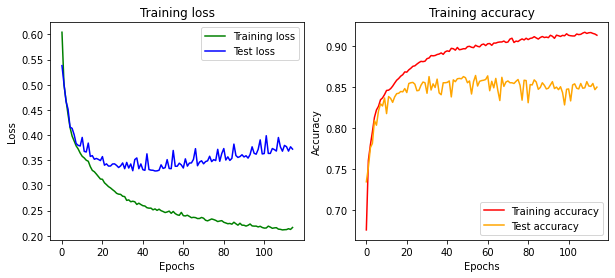

In [ ]:
plt.figure(figsize = (10,4))
plt.subplot(121)
plt.plot(history_adam.epoch, history_adam.history["loss"], 'g', label='Training loss')
plt.plot(history_adam.epoch, history_adam.history["val_loss"], 'b', label='Test loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history_adam.epoch, history_adam.history["accuracy"], 'r', label='Training accuracy')
plt.plot(history_adam.epoch, history_adam.history["val_accuracy"], 'orange', label='Test accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(work_folder + "base_model_deep_no_dropout_adam.png")
plt.show()

# Model ADAM and dropout

In [ ]:
model_adam_dropout = tf.keras.Sequential()

model_adam_dropout.add(tf.keras.layers.Conv1D(filters = 27, kernel_size = 4, activation = 'relu', padding = "valid", input_shape = (X_train.shape[1], X_train.shape[2])))
model_adam_dropout.add(tf.keras.layers.MaxPool1D(pool_size=3, strides=None, padding='valid'))
model_adam_dropout.add(tf.keras.layers.Dropout(0.2))
model_adam_dropout.add(tf.keras.layers.Conv1D(filters = 14, kernel_size = 4, activation = 'relu'))
model_adam_dropout.add(tf.keras.layers.MaxPool1D(pool_size= 2, strides = None, padding = 'valid'))
model_adam_dropout.add(tf.keras.layers.Dropout(0.2))
model_adam_dropout.add(tf.keras.layers.Conv1D(filters = 7, kernel_size = 4, activation = 'relu'))
model_adam_dropout.add(tf.keras.layers.MaxPool1D(pool_size= 2, strides = None, padding = 'valid'))
model_adam_dropout.add(tf.keras.layers.Dropout(0.2))
model_adam_dropout.add(tf.keras.layers.Flatten())
model_adam_dropout.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

model_adam_dropout.summary()

model_adam_dropout.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Set early stopping to avoid overfitting

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0005, patience=8, 
                                           restore_best_weights=True )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 298, 27)           459       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 99, 27)           0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 99, 27)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 96, 14)            1526      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 48, 14)           0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 48, 14)           

In [ ]:
history_adam_droupout = model_adam_dropout.fit(X_train, y_train, batch_size = 128, validation_data=(X_test, y_test), 
                        epochs=115)

model_adam.save(models_folder)

Epoch 1/115
142/142 [==============================] - 8s 48ms/step - loss: 0.6035 - accuracy: 0.6723 - val_loss: 0.5332 - val_accuracy: 0.7491
Epoch 2/115
142/142 [==============================] - 7s 46ms/step - loss: 0.5194 - accuracy: 0.7483 - val_loss: 0.5121 - val_accuracy: 0.7575
Epoch 3/115
142/142 [==============================] - 7s 46ms/step - loss: 0.5050 - accuracy: 0.7566 - val_loss: 0.4890 - val_accuracy: 0.7690
Epoch 4/115
142/142 [==============================] - 7s 46ms/step - loss: 0.4876 - accuracy: 0.7695 - val_loss: 0.4748 - val_accuracy: 0.7708
Epoch 5/115
142/142 [==============================] - 7s 46ms/step - loss: 0.4663 - accuracy: 0.7821 - val_loss: 0.4399 - val_accuracy: 0.7876
Epoch 6/115
142/142 [==============================] - 7s 46ms/step - loss: 0.4482 - accuracy: 0.7930 - val_loss: 0.4201 - val_accuracy: 0.7947
Epoch 7/115
142/142 [==============================] - 8s 59ms/step - loss: 0.4408 - accuracy: 0.7960 - val_loss: 0.4110 - val_accuracy:

In [ ]:
# Evaluate the model
loss, acc = model_adam_dropout.evaluate(X_validation, y_validation, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

71/71 - 0s - loss: 0.2738 - accuracy: 0.8876 - 288ms/epoch - 4ms/step
Untrained model, accuracy: 88.76%


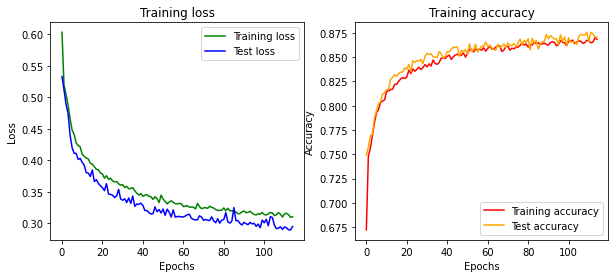

In [ ]:
plt.figure(figsize = (10,4))
plt.subplot(121)
plt.plot(history_adam_droupout.epoch, history_adam_droupout.history["loss"], 'g', label='Training loss')
plt.plot(history_adam_droupout.epoch, history_adam_droupout.history["val_loss"], 'b', label='Test loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history_adam_droupout.epoch, history_adam_droupout.history["accuracy"], 'r', label='Training accuracy')
plt.plot(history_adam_droupout.epoch, history_adam_droupout.history["val_accuracy"], 'orange', label='Test accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(work_folder + "base_model_deep_dropout_adam.png")
plt.show()